## Examples of optimization pathology and success in RL

The following notebook looks at the [hopper pybullet environment](https://github.com/benelot/pybullet-gym) pictured below 

![hopper env](hopperv1.png)

This agent was trained with stable baselines 3's implementation of PPO. The hyperparameters were set to the original paper's hyperparameters. The training distribution looks like this:

![train curve](generated_dirsbullet_evalhopper_resultscsv.png)

Notably, these evaluations are quite precise---all the variation you see are in fact real changes in the policy's quality. 

Our core question is: Why does the reinforcement learning process have so much variance? 

What we found is that the RL objective is profoundly non-smooth. This non-smoothness is so severe that the gradient can become misleading in many situations.

In [44]:
from reward_surfaces.experiments import generate_plane_data
from reward_surfaces.plotting import plot_plane
from reward_surfaces.runners.run_jobs_multiproc import run_job_list
from reward_surfaces.utils.job_results_to_csv import job_results_to_csv
from reward_surfaces.utils.surface_utils import readz
from reward_surfaces.agents.make_agent import make_agent

import json
import os
import shutil

In [41]:
def plot_result(p_str, dir1_mag, dir2_mag, num_episodes=50, grid_size=11, max_eig=False):
    trained_checkpoint = f"train_hopper_small/{p_str}/"
    generated_dirs_dir = f"_temp_dir/"

    dir2_fname = f"hopper_eig_vecs/results/{p_str}/mineigvec.npz"
    if max_eig:
        dir2_fname = f"hopper_eig_vecs/results/{p_str}/maxeigvec.npz"
    dir1_fname = f"hopper_grad/results/{p_str}/grad.npz"

    dir1 = readz(dir1_fname)
    dir2 = readz(dir2_fname)

    train_info = json.load(open(generated_dirs_dir+"info.json"))
    base_magnitude = 1.0
    dir1_mag = dir1_mag * base_magnitude
    dir2_mag = dir2_mag * base_magnitude
    dir1 = [d*dir1_mag/1000000 for d in dir1]
    dir2 = [d*dir2_mag for d in dir2]

    train_info['dir1_mag'] = dir1_mag
    train_info['dir2_mag'] = dir2_mag

    if os.path.exists(generated_dirs_dir):
        shutil.rmtree(generated_dirs_dir)
    print("removed")

    generate_plane_data(trained_checkpoint, generated_dirs_dir, dir1, dir2, train_info, grid_size=grid_size, num_episodes=num_episodes)
    run_job_list(generated_dirs_dir+"jobs.sh",disable_warnings=True)
    job_results_to_csv(generated_dirs_dir)
    plot_plane(generated_dirs_dir+"results.csv",
        outname="script_out",
        type="heat",
        dir1_name=os.path.basename(dir1_fname),
        dir2_name=os.path.basename(dir2_fname),
        dir1_scale=dir1_mag,
        dir2_scale=dir2_mag,
        show=True
        )


How to interpret 

![](gradient_thingy.png)

removed



(11, 11)



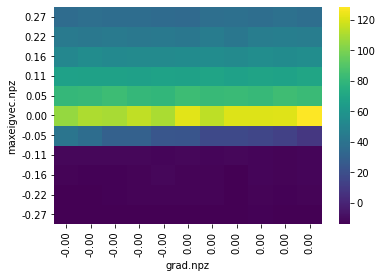

In [26]:
plot_result("0160000", 0.001, 0.3, num_episodes=200)

As you can see, if you zoom up, the policy gradient looks like a gradient

removed



(11, 11)


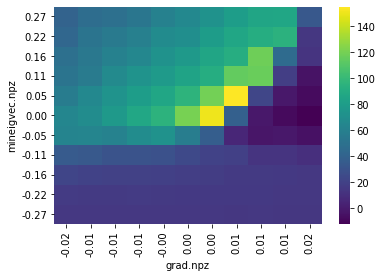

In [3]:
plot_result("0160000", 0.02, 0.3)

As you would expect, going in the direction of the graident is the shortest route to improving performance. However, if you follow the gradient even a little bit further, the value plumets to zero! Bizzarely, if you take a too big gradient step in the direction of the gradient, not even too far, just with an LR of 0.02, you end up with total policy collapse. You would have been better off stepping in the negative direction of the gradient. 

removed



(11, 11)


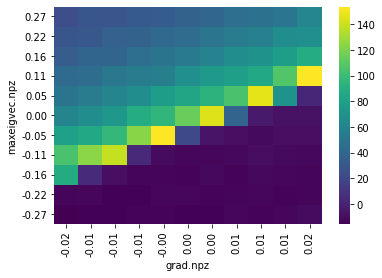

In [38]:
plot_result("0160000", 0.02, 0.3,max_eig=True)

Plotted along a pathological direction, the situation starts to look even worse.

removed



(11, 11)


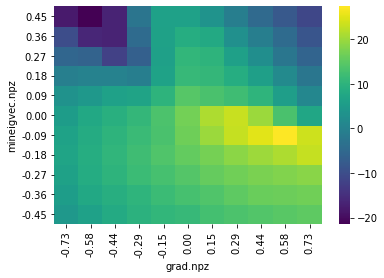

In [9]:
plot_result("0040000", 0.8, 0.5, num_episodes=200)

Early in training, when the objective is more smooth, the gradient direction smoothly increases and decreases, even for extremely large gradient steps.

removed



(11, 11)


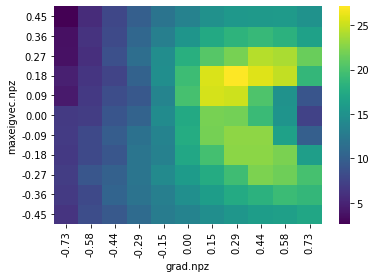

In [36]:
plot_result("0040000", 0.8, 0.5, num_episodes=200,max_eig=True)

Even when plotted against the most pathological direction, the gradient still looks informative (if not completely ideal). 

removed



(11, 11)


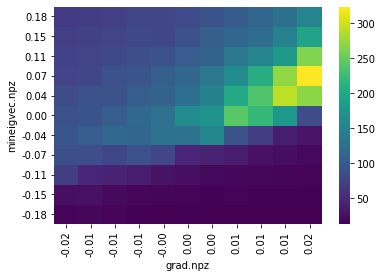

In [42]:
plot_result("0320000", 0.02, 0.2, num_episodes=50)

Later in training, when the objective is less convex, the objective quickly becomes this sharper, risker landscape.

removed



(11, 11)


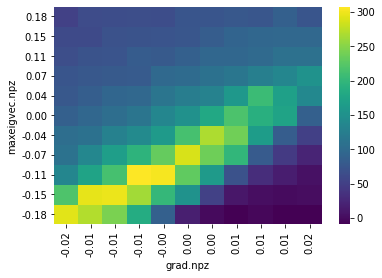

In [35]:
plot_result("0320000", 0.02, 0.2, num_episodes=50,max_eig=True)

When you start plotting the gradient against the pathological direction, the direction of maximum curvature, the gradient sometimes looks uninformative. In a convex environment there would be no curvature upwards.

removed



(11, 11)


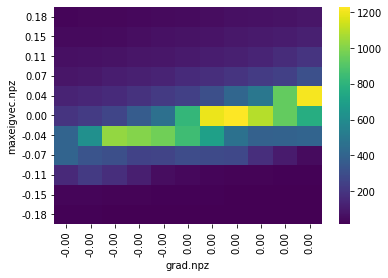

In [33]:
plot_result("2560000", 0.0005, 0.2, num_episodes=50)

Furthur along training, the objective gets another order of magnitude more sharp with the appropirate gradient size shrinking dramatically. Not only that, but bizzarely, in this cross section of two gradient dimentions, the correct direction to train via eyeball is in the wrong direction of the actual gradient. 

removed



(11, 11)


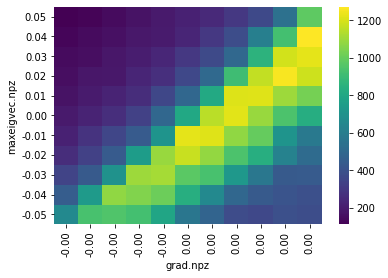

In [25]:
plot_result("2560000", 0.0005, 0.05, num_episodes=50,max_eig=True)

And of course if you look in a different direction, it ends up being beneficial to step in the direction of the positive gradient. 

removed



(31, 31)


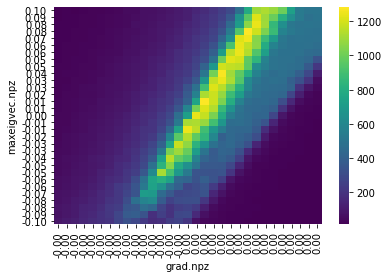

In [29]:
plot_result("2560000", 0.002, 0.10, num_episodes=50,grid_size=31,max_eig=True)

This view shows a very sharp line where the objective is high at around 1200 reward, with a stable platu aroun dit with reward at the 800 level. This helps explain why the oscelating reward doesn't go beneath 800 -- there is a strong support of that reward in the policy space. 